### 一個檢查算法沒有錯的東東
做 HCN/CO 的 ratio map

嘗試復現論文裡的操作：
1.5 arcsec 的網格和 3*3 arcsec 的 beam

先都做成對齊良好 moment map (file 1, 2)，再卷積，再將 HCN 變得和 CO 一樣 shape

對齊的方式都是用函式，平行處理的概念。

但是這個不是最好的版本，因為 HCN 投影第二次好像會有點跑掉...

檔案如下：
1. CO(1-0)_mom0_oldData_regrid1.5.fits
2. HCN(1-0)_mom0_oldData_regrid1.5.fits
3. CO(1-0)_mom0_oldData_regrid1.5_convol33.fits
4. HCN(1-0)_mom0_oldData_regrid1.5_convol33.fits
5. HCN-CO_ratio_oldData_regrid1.5_convol33.fits

In [1]:
# import modular

from astropy.io import fits
import matplotlib.pyplot as plt

from astropy.wcs import WCS
from reproject import reproject_interp

from radio_beam import Beam
from astropy.convolution import convolve_fft
from astropy import units as u

import numpy as np

In [2]:
# hand made function

# 存檔芝士
def Save_as_FITS(the_file_name, ima_data, ref_header, ref_beam, beam_a_Beam):
    the_file_name = the_file_name + '.fits'
    the_header = ref_header.copy() # new header 是複製一個已知 header 的大部分...
    if beam_a_Beam == True: # ref_beam 是實際意義上的 Beam 的話
        the_header['BMAJ'] = ref_beam.major.to(u.deg).value
        the_header['BMIN'] = ref_beam.minor.to(u.deg).value
        the_header['BPA'] = ref_beam.pa.to(u.deg).value
    else: # ref_beam 是一個 header 的話
        the_header['BMAJ'] = ref_beam['BMAJ']
        the_header['BMIN'] = ref_beam['BMIN']
        the_header['BPA'] = ref_beam['BPA']
    fits.writeto(the_file_name, ima_data, the_header, overwrite=True)
    print(f'Successfully saved a new FITS file as {the_file_name}')


# 新網格機！
'''
input a hdul&&像素步長 in arcsec
return new_shape, new_wcs, 和定義的 header 本人 
'''
def reGrid(reGrid_obj, pixelStep_target): 
    reGrid_obj_header = reGrid_obj[0].header
    ori_n1, ori_n2 = reGrid_obj[0].data.squeeze().shape # (y, x)
    print('Get the input HDUL successfully!') ##
    new_n2 = int(ori_n2*abs(reGrid_obj_header['CDELT1']) / (pixelStep_target/3600)) # 要純量相除！
    new_n1 = int(ori_n1*abs(reGrid_obj_header['CDELT2']) / (pixelStep_target/3600))
    new_header = fits.Header()
    new_header['NAXIS'] = 2
    new_header['NAXIS1'] = new_n2
    new_header['NAXIS2'] = new_n1
    new_header['CRPIX1'] = new_n2 * 0.5 + 1
    new_header['CRPIX2'] = new_n1 * 0.5 + 1
    new_header['CRVAL1'] = 213.2915 # 暴力抓蟲
    new_header['CRVAL2'] = -65.339 # 暴力抓蟲
    new_header['CDELT1'] = pixelStep_target / -3600
    new_header['CDELT2'] = pixelStep_target / 3600
    new_header['CTYPE1'] = 'RA---SIN'
    new_header['CTYPE2'] = 'DEC--SIN'
    new_header['CUNIT1'] = 'deg'
    new_header['CUNIT2'] = 'deg'
    ## 不確定但先寫著，沒 beam 很奇怪耶
    new_header['BMAJ'] = reGrid_obj_header['BMAJ']
    new_header['BMIN'] = reGrid_obj_header['BMIN']
    new_header['BPA'] = reGrid_obj_header['BPA']
    print('Giving reprojecting material...')
    return (new_n2, new_n1), WCS(new_header), new_header

In [3]:
# import data (moment0.fit of CO&&HCN)

CO_hdul = fits.open("/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/oldData/CO(1-0)_mom0_oldData.fits")
HCN_hdul = fits.open("/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/oldData/HCN(1-0)_mom0_oldData.fits")

CO_header, HCN_header = CO_hdul[0].header, HCN_hdul[0].header
CO_ima, HCN_ima = CO_hdul[0].data.squeeze(), HCN_hdul[0].data.squeeze()

original_wcs = WCS(CO_header)
print("Original WCS is valid:", original_wcs.is_celestial)

Original WCS is valid: False


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [4]:
# reproject to 1.5 arc ㄉ 網格

CO_wcs, HCN_wcs = WCS(CO_header, naxis=2), WCS(HCN_header, naxis=2)
pixelStep = 1.5 # arcsec
CO_new_shape, CO_new_wcs, CO_new_header = reGrid(CO_hdul, pixelStep)
CO_ima_reproj, _ = reproject_interp((CO_ima, CO_wcs), CO_new_wcs, shape_out=CO_new_shape)

HCN_new_shape, HCN_new_wcs, HCN_new_header = reGrid(HCN_hdul, pixelStep) # 用自訂函式進行對齊
HCN_ima_reproj, _ = reproject_interp((HCN_ima, HCN_wcs), HCN_new_wcs, shape_out=HCN_new_shape)

Get the input HDUL successfully!
Giving reprojecting material...
Get the input HDUL successfully!
Giving reprojecting material...


In [5]:
# save regridded plots as FITS

Save_as_FITS("CO(1-0)_mom0_oldData_regrid1.5", CO_ima_reproj, CO_new_header, CO_new_header, False)
Save_as_FITS("HCN(1-0)_mom0_oldData_regrid1.5", HCN_ima_reproj, HCN_new_header, HCN_new_header, False)

Successfully saved a new FITS file as CO(1-0)_mom0_oldData_regrid1.5.fits
Successfully saved a new FITS file as HCN(1-0)_mom0_oldData_regrid1.5.fits


In [6]:
# show regridded plots
'''
plt.figure(1) 
plt.subplot(projection=CO_new_wcs)
plt.imshow(CO_ima_reproj, cmap='jet', vmin=0)
plt.colorbar()
plt.title("CO(1-0) mom0_reprojecteed")
plt.figure(2)
plt.subplot(projection=HCN_new_wcs)
plt.imshow(HCN_ima_reproj, cmap='jet', vmin=0)
plt.colorbar()
plt.title("HCN(1-0) mom0_reprojecteed")

plt.figure(3)
plt.subplot(projection=HCN_wcs)
plt.imshow(HCN_ima)
'''
#plt.show()

'\nplt.figure(1) \nplt.subplot(projection=CO_new_wcs)\nplt.imshow(CO_ima_reproj, cmap=\'jet\', vmin=0)\nplt.colorbar()\nplt.title("CO(1-0) mom0_reprojecteed")\nplt.figure(2)\nplt.subplot(projection=HCN_new_wcs)\nplt.imshow(HCN_ima_reproj, cmap=\'jet\', vmin=0)\nplt.colorbar()\nplt.title("HCN(1-0) mom0_reprojecteed")\n\nplt.figure(3)\nplt.subplot(projection=HCN_wcs)\nplt.imshow(HCN_ima)\n'

In [7]:
# convole to 3*3 beam

CO_beam, HCN_beam = Beam.from_fits_header(CO_header), Beam.from_fits_header(HCN_header) # 原始束寬應該和投影過後的束寬一樣
# make a 3*3 circle beam
pixelScale = 2*u.arcsec ##
tarBeam = Beam(major=3*u.arcsec, minor=3*u.arcsec, pa=0*u.deg)
kernel = tarBeam.as_kernel(pixscale=pixelScale)
CO_ima_final = convolve_fft(CO_ima_reproj, kernel)
HCN_ima_final = convolve_fft(HCN_ima_reproj, kernel)

print('initial beams:')
print('CO ', CO_beam)
print('HCN', HCN_beam)
print("THE", tarBeam)
print()
print(f"kernel shape: {kernel.shape}")
print(f"image shape: {CO_new_shape} && {HCN_new_shape}")
print('** if ur kernel is so much bigger than image, you will get 一坨 :-(')
print()
print('Successfully convolved the image !')


initial beams:
CO  Beam: BMAJ=2.58261942863448 arcsec BMIN=2.00552678108208 arcsec BPA=69.03997802734 deg
HCN Beam: BMAJ=2.8900502045118 arcsec BMIN=2.6833899342286798 arcsec BPA=-18.78534477377 deg
THE Beam: BMAJ=3.0 arcsec BMIN=3.0 arcsec BPA=0.0 deg

kernel shape: (11, 11)
image shape: (106, 106) && (75, 75)
** if ur kernel is so much bigger than image, you will get 一坨 :-(

Successfully convolved the image !


In [8]:
# save convol plots as FITS

Save_as_FITS("CO(1-0)_mom0_oldData_regrid1.5_convol33", CO_ima_final, CO_new_header, tarBeam, True)
Save_as_FITS("HCN(1-0)_mom0_oldData_regrid1.5_convol33", HCN_ima_final, HCN_new_header, tarBeam, True)

Successfully saved a new FITS file as CO(1-0)_mom0_oldData_regrid1.5_convol33.fits
Successfully saved a new FITS file as HCN(1-0)_mom0_oldData_regrid1.5_convol33.fits


In [9]:
# show convoled plots
'''
plt.figure(4) 
plt.subplot(projection=CO_new_wcs)
plt.imshow(CO_ima_final, cmap='jet', vmin=0)
plt.colorbar()
plt.title("CO(1-0) mom0_reproj_convol")
plt.figure(5)
plt.subplot(projection=HCN_new_wcs)
plt.imshow(HCN_ima_final, cmap='jet', vmin=0)
plt.colorbar()
plt.title("HCN(1-0) mom0_reproj_convol")

plt.figure(6)
plt.subplot(projection=HCN_new_wcs)
plt.imshow(HCN_ima_reproj, cmap='jet', vmin=0)
plt.colorbar()
plt.title("HCN(1-0) mom0_reproj")
'''
#plt.show()

'\nplt.figure(4) \nplt.subplot(projection=CO_new_wcs)\nplt.imshow(CO_ima_final, cmap=\'jet\', vmin=0)\nplt.colorbar()\nplt.title("CO(1-0) mom0_reproj_convol")\nplt.figure(5)\nplt.subplot(projection=HCN_new_wcs)\nplt.imshow(HCN_ima_final, cmap=\'jet\', vmin=0)\nplt.colorbar()\nplt.title("HCN(1-0) mom0_reproj_convol")\n\nplt.figure(6)\nplt.subplot(projection=HCN_new_wcs)\nplt.imshow(HCN_ima_reproj, cmap=\'jet\', vmin=0)\nplt.colorbar()\nplt.title("HCN(1-0) mom0_reproj")\n'

In [10]:
# ratio mappppp

# 統一 shape 才能相除
HCN_ima_final_reproj, _ = reproject_interp((HCN_ima_final, HCN_new_wcs), CO_new_wcs, shape_out=CO_new_shape)

with np.errstate(divide='ignore', invalid='ignore'):
    #ratioMap = np.where(CO_ima_final>3*10**(-3), HCN_ima_final_reproj/CO_ima_final, np.nan)
    ratioMap = np.where(CO_ima_final!=0, HCN_ima_final_reproj/CO_ima_final, np.nan)

In [11]:
# save ratio map as FITS

Save_as_FITS("HCN-CO_ratio_oldData_regrid1.5_convol33", ratioMap, CO_new_header, tarBeam, True)

Successfully saved a new FITS file as HCN-CO_ratio_oldData_regrid1.5_convol33.fits


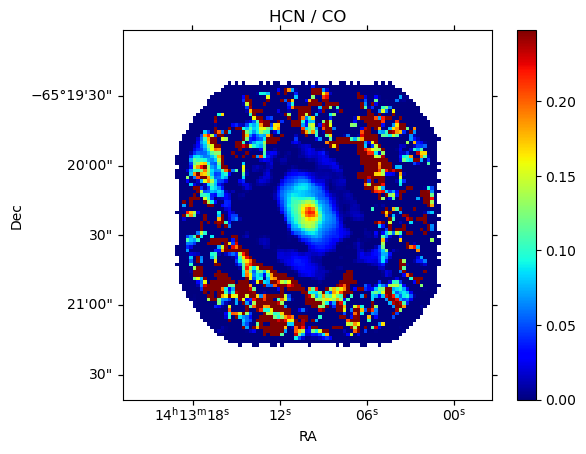

In [12]:
# show the ratio map
# 我算的比值就是比較大是三小
plt.figure(7)
plt.subplot(projection=CO_new_wcs)
plt.imshow(ratioMap, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ratioMap, 88))
#plt.imshow(ratioMap, cmap='jet') #inferno
#plt.imshow(ratioMap, origin='lower', cmap='jet', vmin=0, vmax=0.28)
plt.title("HCN / CO")
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()